In [15]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain_openai import OpenAIEmbeddings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics.pairwise import cosine_similarity

os.environ["NEO4J_URI"] ='bolt://localhost:7687'
os.environ["NEO4J_USERNAME"]='neo4j'
os.environ["NEO4J_PASSWORD"]='password'
os.environ["OPENAI_API_KEY"] = "sk-"

graph = Neo4jGraph()

# Append questions

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [25]:
data = graph.query("""
MATCH (a:Article)-[:HAS_CHUNK]->(c:Chunk)
RETURN a.title AS title, a.sentiment AS sentiment, toString(a.date) AS date, c.text AS text, c.embedding AS embedding
""")

# Generate embeddings for the questions
question1 = "What is the latest news?"
question2 = "Which article has the lowest sentiment?"

embedding1 = embeddings.embed_query(question1)
embedding2 = embeddings.embed_query(question2)

# Create new rows for the questions
new_rows = [
    {
        'title': 'latest',
        'sentiment': None,
        'date': None,
        'text': question1,
        'embedding': embedding1
    },
    {
        'title': 'sentiment',
        'sentiment': None,
        'date': None,
        'text': question2,
        'embedding': embedding2
    }
]

df = pd.DataFrame.from_records(data + new_rows)
df['date'] = pd.to_datetime(df['date'])
# Extract embeddings into a numpy array
X = np.array(df['embedding'].tolist())

# Create a UMAP model
umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='euclidean')

# Fit the model and transform the data
umap_result = umap_model.fit_transform(X)

# Add UMAP results to the DataFrame
df['UMAP1'] = umap_result[:, 0]
df['UMAP2'] = umap_result[:, 1]

In [26]:
df.head()

,title,sentiment,date,text,embedding,UMAP1,UMAP2
0,What's Going On In The Tunnels Under Las Vegas?,0.680,2024-07-21T18:37:00Z,in Turkey as tourists abandon country for ano...,"[-0.024917878210544586, 0.024496600031852722, ...",9.113962,8.523739
1,What's Going On In The Tunnels Under Las Vegas?,0.680,2024-07-21T18:37:00Z,"Underneath the Las Vegas Strip, one of the mos...","[0.007297842763364315, 0.01533298660069704, -0...",9.089078,8.609286
2,Amazon Prime Day Sale 2024 ends soon: Round up...,0.966,2024-07-21T17:30:00Z,"Sound: 30W Output, Dolby Audio, DTS-X\nSpecial...","[0.014354412443935871, 0.01019231416285038, -0...",5.054927,11.113036
3,Amazon Prime Day Sale 2024 ends soon: Round up...,0.966,2024-07-21T17:30:00Z,", Smart Diagnosis\n6. Samsung 236 L, 3 Star, D...","[0.0022865920327603817, 0.00859488733112812, -...",4.990681,11.179895
4,Amazon Prime Day Sale 2024 ends soon: Round up...,0.966,2024-07-21T17:30:00Z,"Intel Core i7-13620H 15"" (38.1cm) FHD IPS 300...","[0.0026402389630675316, -0.0185304656624794, -...",5.139641,11.008223


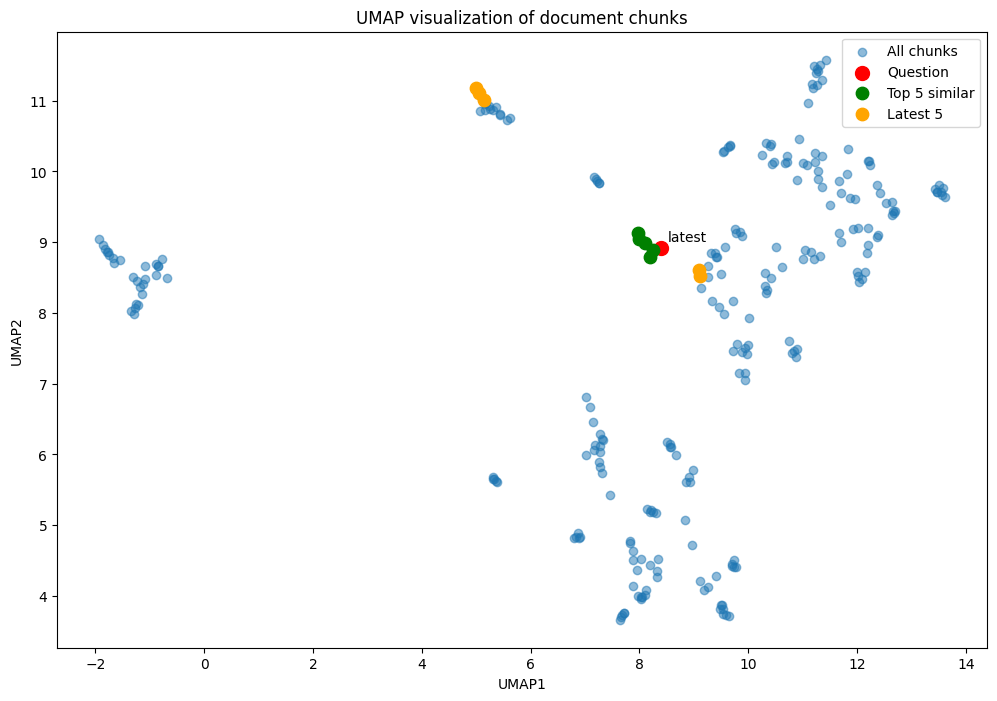

In [29]:
# Calculate similarity to the "latest" question
latest_embedding = df[df['title'] == 'latest']['embedding'].iloc[0]
similarities = cosine_similarity([latest_embedding], X)[0]
df['similarity_to_latest'] = similarities

# Get top 5 most similar chunks (excluding the question itself)
top_5_similar = df[df['title'] != 'latest'].nlargest(5, 'similarity_to_latest')

# Get 5 most recent chunks by date
latest_5 = df[df['date'].notna()].nlargest(5, 'date')

# Visualization
plt.figure(figsize=(12, 8))

# Plot all points
plt.scatter(df['UMAP1'], df['UMAP2'], alpha=0.5, label='All chunks')

# Highlight questions
questions = df[df['title'].isin(['latest'])]
plt.scatter(questions['UMAP1'], questions['UMAP2'], color='red', s=100, label='Question')

# Highlight top 5 similar chunks
plt.scatter(top_5_similar['UMAP1'], top_5_similar['UMAP2'], color='green', s=80, label='Top 5 similar')

# Highlight latest 5 chunks
plt.scatter(latest_5['UMAP1'], latest_5['UMAP2'], color='orange', s=80, label='Latest 5')

plt.legend()
plt.title('UMAP visualization of document chunks')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Add annotations
for _, row in questions.iterrows():
    plt.annotate(row['title'], (row['UMAP1'], row['UMAP2']), xytext=(5, 5), textcoords='offset points')


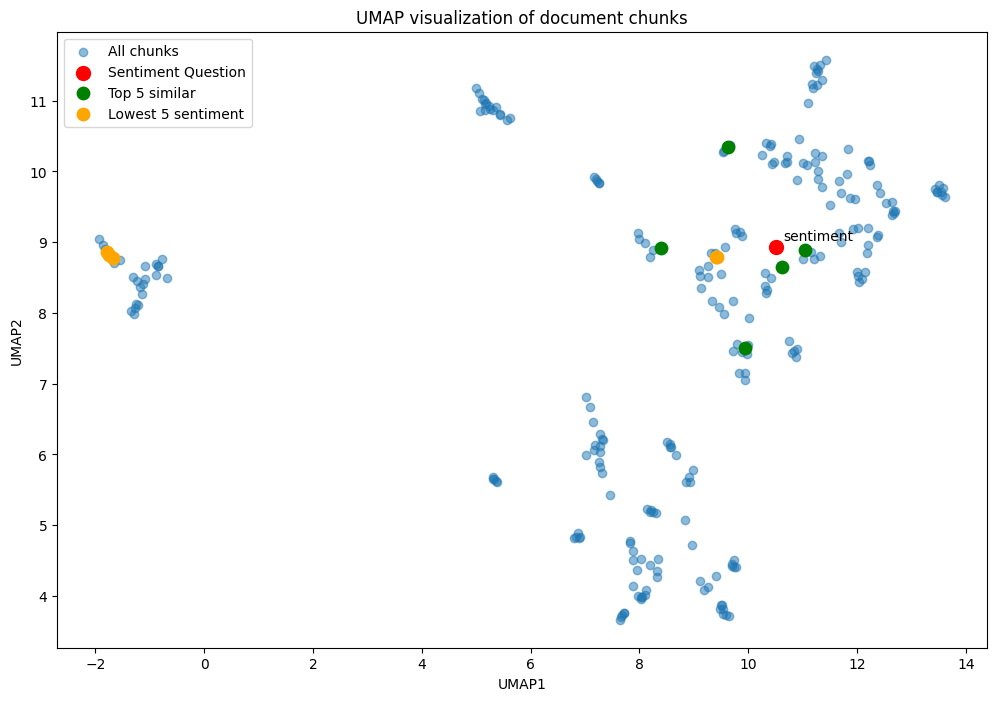

In [30]:
# Calculate similarity to the "sentiment" question
sentiment_embedding = df[df['title'] == 'sentiment']['embedding'].iloc[0]
similarities = cosine_similarity([sentiment_embedding], X)[0]
df['similarity_to_sentiment'] = similarities

# Get top 5 most similar chunks (excluding the question itself)
top_5_similar = df[df['title'] != 'sentiment'].nlargest(5, 'similarity_to_sentiment')

# Get 5 chunks with the lowest sentiment value
lowest_5_sentiment = df[df['sentiment'].notna()].nsmallest(5, 'sentiment')

# Visualization
plt.figure(figsize=(12, 8))

# Plot all points
plt.scatter(df['UMAP1'], df['UMAP2'], alpha=0.5, label='All chunks')

# Highlight questions
questions = df[df['title'].isin(['sentiment'])]
plt.scatter(questions['UMAP1'], questions['UMAP2'], color='red', s=100, label='Sentiment Question')

# Highlight top 5 similar chunks
plt.scatter(top_5_similar['UMAP1'], top_5_similar['UMAP2'], color='green', s=80, label='Top 5 similar')

# Highlight 5 chunks with lowest sentiment
plt.scatter(lowest_5_sentiment['UMAP1'], lowest_5_sentiment['UMAP2'], color='orange', s=80, label='Lowest 5 sentiment')

plt.legend()
plt.title('UMAP visualization of document chunks')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Add annotations
for _, row in questions.iterrows():
    plt.annotate(row['title'], (row['UMAP1'], row['UMAP2']), xytext=(5, 5), textcoords='offset points')

plt.show()